In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import zipfile
from keras.layers import Conv2DTranspose
from tensorflow.keras import mixed_precision
#import splitfolders
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers


from skimage.io import imread
from PIL import Image, ImageDraw
import cv2 as cv
import math
import h5py
from keras.models import load_model
import json

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Nagasaki_summer_internship/Sliced_Dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
image_size = 64
channels = 3

In [ ]:
def draw_square_on_image(image):
    
    output_img = image
    random_start_point = np.random.randint(0,100)

    img_draw = ImageDraw.Draw(Image.fromarray((output_img* 255).astype(np.uint8)))
    img_draw.rectangle([(random_start_point,random_start_point),(random_start_point+28,random_start_point+28)], fill='black')
    return output_img

In [ ]:
from io import StringIO 

In [ ]:
def custom_image_generator(files, data_instances, batch_size = 16):
    # to keep track that you don't have invalid index for number of files
    iter = 0
    
    while True:
        # check if you have a invalid index for files, if yes then reset it
        if (iter*batch_size + batch_size) > len(files):
          iter= 0
        end_iter = iter*batch_size + batch_size
        # Select files (paths/indices) for the batch
        paths = files[iter*batch_size:end_iter]
        # Read in each input and perform preprocessing (to batch of images)
        corrupted_images_batch = []
        original_images_batch = []
        for path in paths:
          img =  Image.open(path)
          img = np.array(img)
          img = (img/255)
          original_images_batch.append(img)
        
          masked_img = draw_square_on_image(img)
          preprocess_img = np.array(masked_img)
          preprocess_img = (preprocess_img/255).astype(np.float16)
          
          #preprocess_img = (preprocess_img/255).astype(np.float16)
          corrupted_images_batch.append(preprocess_img)
        # Return a tuple of (corrupted_image_batch, true_image_batch) to feed the network
        corrupted_images_batch = np.array(corrupted_images_batch,dtype = object)
        original_images_batch = np.array(original_images_batch,dtype = object)
        # move to the next batch
        iter = iter + 1
    
        yield (corrupted_images_batch, original_images_batch)

In [ ]:
from keras.layers.convolutional import UpSampling2D
from keras.layers.pooling import MaxPooling3D
from keras.layers.pooling import AveragePooling2D
image_shape = (image_size,image_size,channels)
image = Input(shape=image_shape)

input_shape = image_shape

In [ ]:
from keras.layers import LeakyReLU
from keras import backend as K

In [ ]:
x1=  Conv2D(128, (3, 3),strides = (1,1), activation='relu',padding='same',kernel_initializer='he_uniform')(image)

x2 = Conv2D(128,(3,3),activation = 'relu',strides = (1,1),padding  = 'same',kernel_initializer='he_uniform')(image)

x3 = Conv2D(128,(3,3),activation = 'relu',strides = (1,1), padding  = 'same',kernel_initializer='he_uniform')(image)

p1 = Conv2DTranspose(1,(3,3),strides = (1,1), activation='relu',padding='same',kernel_initializer='he_uniform')(x1)
p2 = Conv2DTranspose(1,(3,3),strides = (1,1), activation='relu',padding='same',kernel_initializer='he_uniform')(x2)
p3 = Conv2DTranspose(1,(3,3),strides = (1,1), activation='relu',padding='same',kernel_initializer='he_uniform')(x3)

out = layers.concatenate([p1,p2,p3])

#encoder part

INPUT_DIM = (128,128,3)

Z_DIM = [20, 100, 300, 5000] 

ae_encoder = None
ae_encoder_output = None
#ae_encoder_input = Input(shape = INPUT_DIM, dtype=np.float32)

num_conv = {0: {'filters': 128, 'kernel_size': 5, 'strides': 2},
            1: {'filters': 64, 'kernel_size': 3, 'strides': 2},
            2: {'filters': 32, 'kernel_size': 3, 'strides': 2}}



encoder = out

for layer_num,layer_data in num_conv.items():

  encoder = Conv2D(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(encoder)
  encoder = MaxPooling2D((2,2),padding='same')(encoder)
  encoder = LeakyReLU(alpha=0.2)(encoder)
  encoder = BatchNormalization(axis=-1)(encoder)

volumeSize = K.int_shape(encoder)
flatten = Flatten()(encoder)
ae_encoder_output = Dense(Z_DIM[2])(flatten)
#ae_encoder = Model(ae_encoder_input,ae_encoder_output)
p_model_1 = Model(inputs = image, outputs = ae_encoder_output)

p_model_1.summary()









Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                              

In [ ]:
from keras.layers import Activation
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                9632      
                                                                 
 reshape (Reshape)           (None, 1, 1, 32)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 2, 2, 32)         9248      
 ranspose)                                                       
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 32)         0         
 )                                                               
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 4, 4, 32)          0   

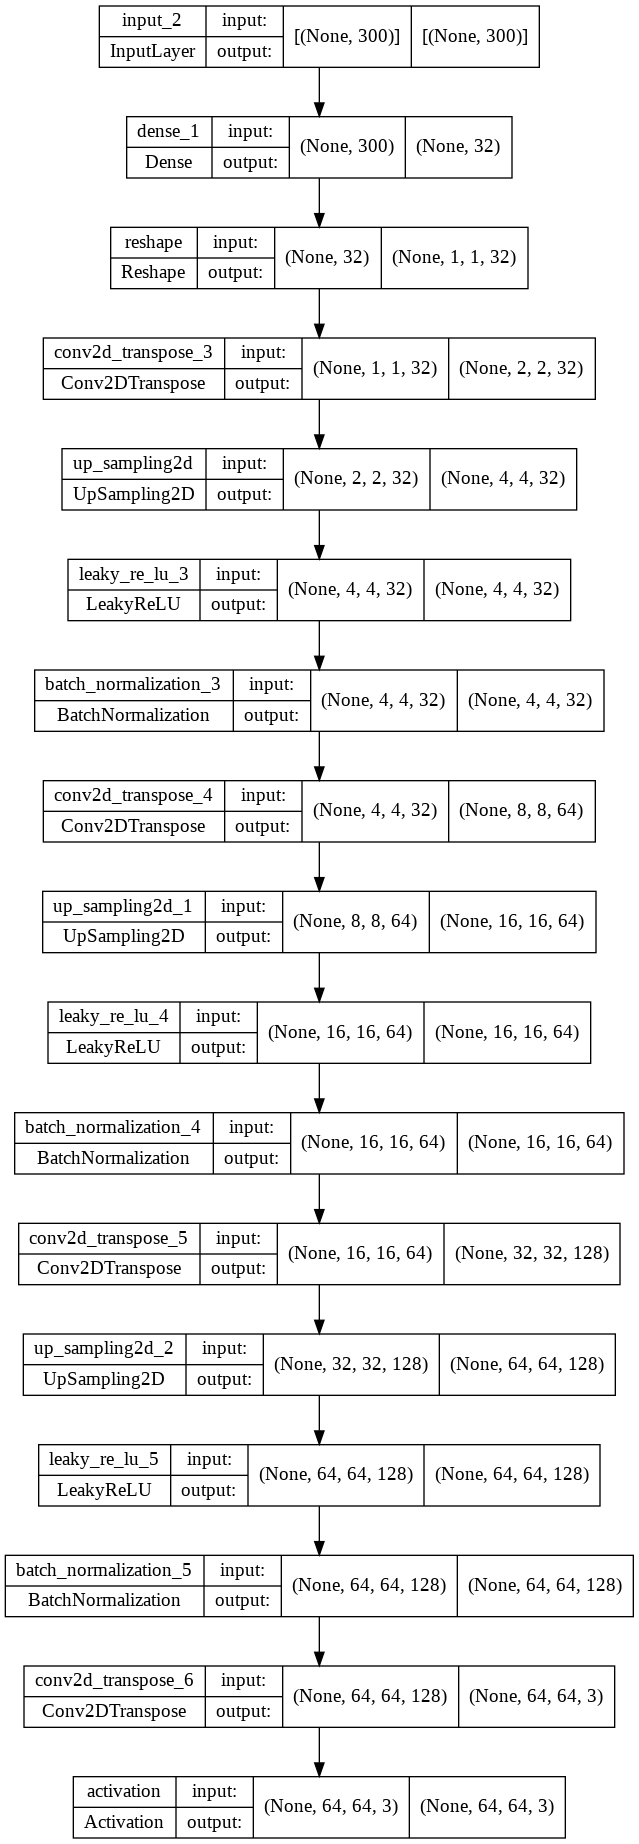

In [ ]:
#DECODER

ae_decoder = None
ae_decoder_output = None
ae_decode_input = Input(shape=(Z_DIM[2],))
decoder = Dense(np.prod(volumeSize[1:]))(ae_decode_input)
decoder = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(decoder)

for layer_num,layer_data in reversed(sorted(num_conv.items())):
  decoder = Conv2DTranspose(layer_data['filters'], layer_data['kernel_size'], layer_data['strides'], padding='same')(decoder)
  decoder = UpSampling2D(size=(2,2))(decoder)
  decoder = LeakyReLU(alpha=0.2)(decoder)
  decoder = BatchNormalization(axis=-1)(decoder)

decoder = Conv2DTranspose(3, 3, padding='same')(decoder)
ae_decoder_output = Activation('sigmoid')(decoder)
ae_decoder = Model(ae_decode_input, ae_decoder_output)

ae_decoder.summary()
tf.keras.utils.plot_model(ae_decoder, show_shapes=True)

In [ ]:
#merging encoder and decoder


autoencoder_model = None
# The input of the autoencoder will be the same as of encoder
autoencoder_input = image
# The output of the autoencoder will be the output of decoder, when passed encoder input
autoencoder_output =  ae_decoder(ae_encoder_output)
# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
autoencoder_model = Model(autoencoder_input, autoencoder_output)
autoencoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 64, 128)  3584        ['input_1[0][0]']                
                                                                                            

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow.keras.optimizers import Adam,SGD
import os

In [ ]:
data_paths = [i for i in (os.path.join("/content/Dataset/Original", f) for f in os.listdir("/content/Dataset/Original")) if os.path.isfile(i)]
x = np.asarray(data_paths)

In [ ]:
data_paths

In [ ]:
train_d = ImageDataGenerator(
        rescale=1./255,

)

train_generator_1 = train_d.flow_from_directory(
        "/content/Dataset",
        target_size=(image_size,image_size),
        batch_size=16,
        class_mode=None,

        #save_to_dir = "/content/drive/MyDrive/J_comp_Neural_network/dataset/augmented_images"

)

Found 600 images belonging to 2 classes.


In [ ]:
#TRAINING
NUM_IMAGES = 300

BATCH_SIZE =  [8] #batch of images returned by image generator
N_EPOCHS = [15]    #epochs
LEARNING_RATE = [0.01,0.001]  #learning rate
OPTIMIZERS = [Adam(),SGD()]
LOSS = ['mse']

model = 0
save_model_paths = []
for batch_size in BATCH_SIZE:
  for epoch in N_EPOCHS:
    for learning_rate in LEARNING_RATE:
      for optimizer in OPTIMIZERS:
        for k_loss in LOSS:
          optim = optimizer
          print('epoch : ', epoch, ' lr : ', learning_rate, ' batch size : ', batch_size, ' optim : ', ' loss: ', k_loss)
          train_generator = custom_image_generator(x, NUM_IMAGES, batch_size) ## CREATE CUSTOM GENERATOR
          optim.learning_rate = learning_rate
          autoencoder_model.compile(loss=k_loss,optimizer = optim, metrics='accuracy') ## MODEL COMPILING
          autoencoder_model.fit(train_generator, steps_per_epoch=6, epochs=epoch)


          ## RECONSTRUCTION
          test_gen = custom_image_generator(x, NUM_IMAGES, batch_size)
          test_batch = next(test_gen)[0]
          test_images = test_batch[:10]
          reconst_images = autoencoder_model.predict(test_images)
          display_image_grid(test_images, 2, 5, "Incomplete Images")
          display_image_grid(reconst_images, 2, 5, "Reconstructed Images with Autoencoder")


In [ ]:

p_model_1 = Model(inputs = image, outputs = out)
mse = tf.keras.losses.MeanSquaredError()

p_model_1.compile(optimizer= 'adam' , loss=mse, metrics=['accuracy'])